# [ EXPLORATION ] 12. 문자를 읽을 수 있는 딥러닝

✅문자를 읽는 OCR 모델의 구조를 배우고, keras-ocr과 테서렉트 엔진을 써본다.

---
### - 📖목차
* ✔️12-9. 프로젝트 : 다양한 OCR모델 비교하기
* ✔️회고 및 결론
* ✔️Reference(참고자료)

<br>



## ✔️12-9. 프로젝트 : 다양한 OCR모델 비교하기
---
### Step1. 검증용 데이터셋 준비
- API 사용 테스트

In [1]:
# google-cloud-vision, protobuf, keras_ocr, pytesseract 까지 설치한 다음에 런타임 재시작
%%capture
!sudo pip install google-cloud-vision
!pip install protobuf 
!pip install keras_ocr
!pip install pytesseract

In [1]:
# 모류 로드
import os
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2
import keras_ocr
import glob
import re
import numpy as np

import pytesseract
from PIL import Image, ImageDraw
from pytesseract import Output
import matplotlib.pyplot as pl
from google.cloud import vision
import io

In [2]:
# 데이터 불러오기(코랩 환경이라 google 마운트를 씁니다)
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# 파일 경로 확인(전체)
!ls '/content/gdrive/MyDrive/aiffel/ex_12' #프로젝트에 쓰게될 이미지들을 가져온 상태

data  my_google_api_key.json


In [2]:
data_path = '/content/gdrive/MyDrive/aiffel/ex_12/data/'
images_path = glob.glob(data_path+"*.png")
images_path

['/content/gdrive/MyDrive/aiffel/ex_12/data/01.png',
 '/content/gdrive/MyDrive/aiffel/ex_12/data/07.png',
 '/content/gdrive/MyDrive/aiffel/ex_12/data/09.png',
 '/content/gdrive/MyDrive/aiffel/ex_12/data/08.png',
 '/content/gdrive/MyDrive/aiffel/ex_12/data/02.png',
 '/content/gdrive/MyDrive/aiffel/ex_12/data/03.png',
 '/content/gdrive/MyDrive/aiffel/ex_12/data/10.png',
 '/content/gdrive/MyDrive/aiffel/ex_12/data/17.png',
 '/content/gdrive/MyDrive/aiffel/ex_12/data/18.png',
 '/content/gdrive/MyDrive/aiffel/ex_12/data/05.png',
 '/content/gdrive/MyDrive/aiffel/ex_12/data/06.png',
 '/content/gdrive/MyDrive/aiffel/ex_12/data/14.png',
 '/content/gdrive/MyDrive/aiffel/ex_12/data/25.png',
 '/content/gdrive/MyDrive/aiffel/ex_12/data/11.png',
 '/content/gdrive/MyDrive/aiffel/ex_12/data/20.png',
 '/content/gdrive/MyDrive/aiffel/ex_12/data/15.png',
 '/content/gdrive/MyDrive/aiffel/ex_12/data/12.png',
 '/content/gdrive/MyDrive/aiffel/ex_12/data/19.png',
 '/content/gdrive/MyDrive/aiffel/ex_12/data/13

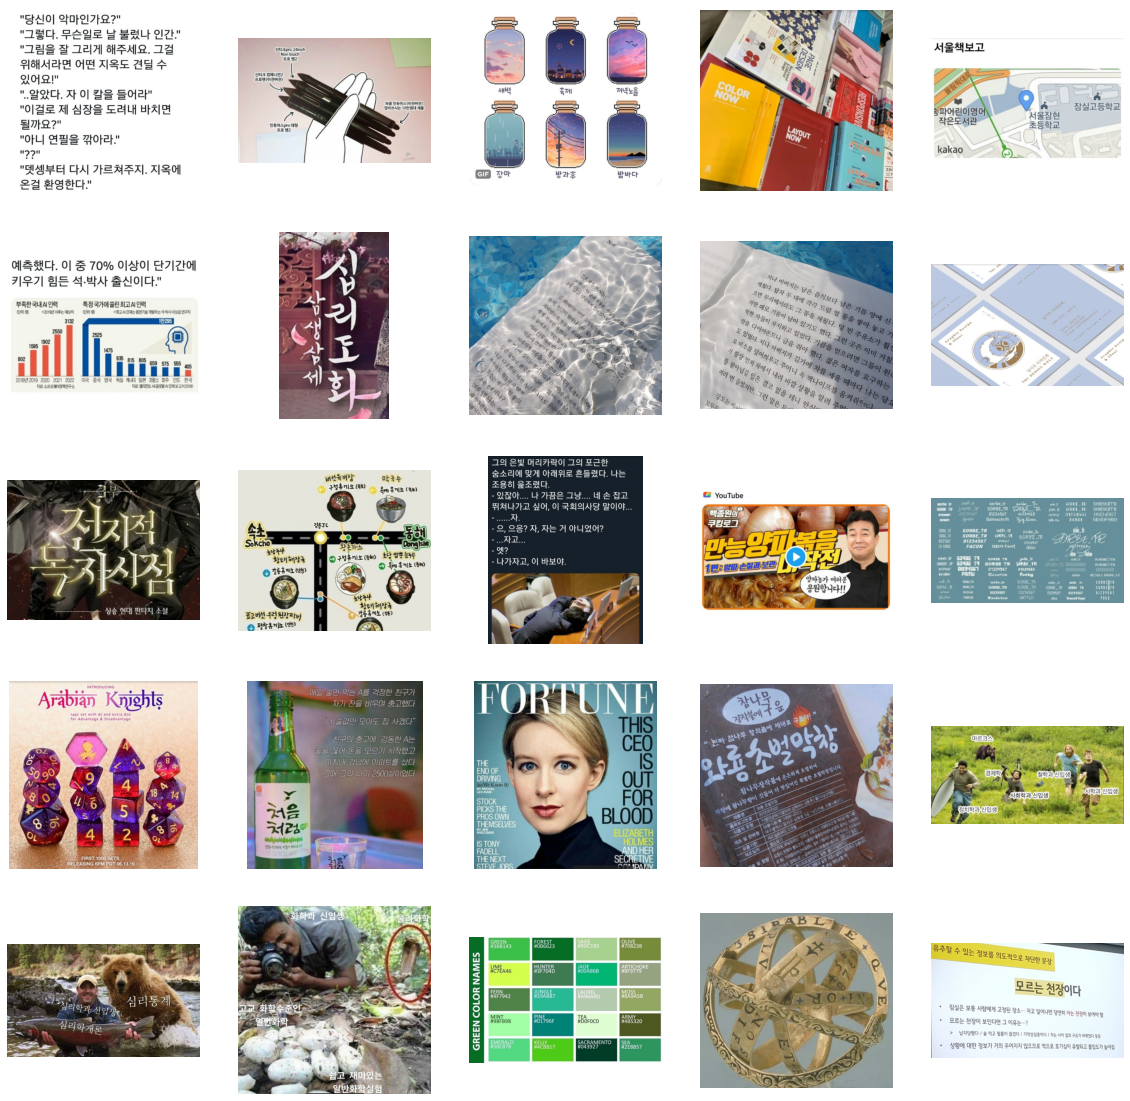

In [3]:
plt.figure(figsize=(20, 20))

for i, image in enumerate(images_path,1):
    plt.subplot(5, 5, i)
    plt.imshow(img.imread(image))
    plt.axis('off')

<br>

### [ - 일상에서 주로 쓰이는 한글 텍스트 감별 - ]

-----

#### - 여기서 데이터로 쓰이는 이미지들의 정보

![다운로드](https://user-images.githubusercontent.com/100528803/173223348-2d74d68a-40f9-40f2-b0e2-b9bbc20c6815.png)

1. 기본텍스트 1개 (흔히 웹에서 보는 텍스트 양식) 
2. 그림 내 텍스트 5개 (그림 내 서로 용도가 다른 텍스트들)
3. 지도 텍스트 2개(지도 정보로 나오는 텍스트)
4. 책 표지 텍스트
5. 그래프 텍스트
6. 세로 텍스트(세로 글씨 타이틀)
7. 물속 내 텍스트(굴절이 심한 상태에서의 텍스트)
8. 명함 텍스트(동시에 각도가 틀어진 텍스트)
9. 작품 타이틀
10. 검은 바탕 위에 텍스트
11. 유투브 타이틀 텍스트
12. 폰트별 텍스트
13. 주사위 텍스트
14. 광고 내 텍스트
15. 잡지 표지 텍스트
16. 포장지 텍스트
17. 색 바탕 텍스트
18. 불규칙 텍스트(복잡한 조형에 쓰여이쓴 텍스트)
19. 구도 있는 텍스트(프리젠테이션 텍스트)

= 일상에서 자주 맞닥드릴 수 있는 여러종류의 텍스트들을 두루 선별해서 총 25종의 텍스트 이미지들을 가져왔다.

- OCR 프로젝트에서 구현하고자 한건 우리 일상에서 흔히 쓰이는 여러 한글 텍스트들을 텍스트 파일로 읽어들일 수 있는지를 가장 큰 테마로 잡았다. 그림 내에 있는 글씨들이나, 지도에서 정확한 장소나 정보를 가져와야 할 때, 폰트나 색상 이미지에서 글씨만 따와야할 때, 수업때 프리젠테이션을 비스듬한 각도에서 찍었을 때 얼마나 읽어들일 수 있는 지 등의 평소에 OCR이 필요할만한 순간들을 하나씩 잡아서 테스트 이미지로 삼았다.

<br>

### - 구글 OCR을 가져와서 간단하게 텐스트

In [43]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

#### - 아래 테스트에서 쓰인 이미지(test_image.png)

<br>

![test_image](https://user-images.githubusercontent.com/100528803/173201575-227b2146-7dbc-41a3-a85a-7e364041ba54.png)

In [17]:
# 제대로 불러와 진 상태인지 테스트
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = '/content/gdrive/MyDrive/aiffel/ex_12/my_google_api_key.json'

# 입력 이미지 경로를 지정
path = '/content/gdrive/MyDrive/aiffel/ex_12/test_image.png'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

Texts:

""당신이 악마인가요?"
"그렇다. 무슨일로 날 불렀나 인간."
"그림을 잘 그리게 해주세요. 그걸
위해서라면 어떤 지옥도 견딜 수
있어요!"
"..알았다. 자 이 칼을 들어라"
"이걸로 제 심장을 도려내 바치면
될까요?"
"아니 연필을 깎아라."
"??"
"뎃셍부터 다시 가르쳐주지. 지옥에
온걸 환영한다.""

"""

"당신"

"이"

"악마"

"인가요"

"?"

"""

"""

"그렇다"

"."

"무슨"

"일로"

"날"

"불렀나"

"인간"

"."

"""

"""

"그림"

"을"

"잘"

"그리게"

"해주세요"

"."

"그걸"

"위해서"

"라면"

"어떤"

"지옥도"

"견딜"

"수"

"있어요"

"!"

"""

"""

".."

"알았다"

"."

"자"

"이"

"칼"

"을"

"들어라"

"""

"""

"이걸로"

"제"

"심장"

"을"

"도려내"

"바치면"

"될까요"

"?"

"""

"""

"아니"

"연필"

"을"

"깎아"

"라"

"."

"""

"""

"??"

"""

"""

"뎃셍"

"부터"

"다시"

"가르쳐"

"주지"

"."

"지옥"

"에"

"온걸"

"환영"

"한다"

"."

"""
bounds: (166,411),(174,411),(174,435),(166,435)


<BR>

### Step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)
-----
#### 1.  keras-ocr

In [10]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


In [11]:
images = [keras_ocr.tools.read(im) for im in images_path]
predictions = [pipeline.recognize([im]) for im in images_path]

In [14]:
fig, axs = plt.subplots(8, 3, figsize=(25, 40))
for a in range(len(axs)):
    for b in range(len(axs[a])):
        keras_ocr.tools.drawAnnotations(image=images[3*a+b], 
                                    predictions=predictions[3*a+b][0], ax=axs[a,b])

Output hidden; open in https://colab.research.google.com to view.

<BR>

#### 2. Tesseract ocr

In [4]:
def detect_box(image_path):
    filename = os.path.basename(image_path)
    # read the image and get the dimensions
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    d = pytesseract.image_to_data(img, output_type=Output.DICT)
    n_boxes = len(d['text'])

    # draw the bounding boxes on the image
    for i in range(n_boxes):
        if int(d['conf'][i]) > 1: # confidence가 1 이상인 값들만
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            text = d['text'][i]
            text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
            cv2.putText(img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        1.5, (0, 0, 255), 3)
    return img

def detect_box(image_path): pytesseract.image_to_data()를 이용해 결과를 pytesseract의 Output 딕셔너리 형식으로 받는다. 검출된 text의 개수 만큼 반복해서 검출 영역의 left, top, width, height 정보를 통해 사각형의 바운딩 박스를 그리고 검출된 text를 이미지 상에 출력하는 함수이다.

In [26]:
%%capture
!sudo apt install tesseract-ocr
!pip install pytesseract
!sudo apt-get install tesseract-ocr-kor

In [5]:
!tesseract --list-langs

List of available languages (3):
osd
kor
eng


In [6]:
# confidence = 1
plt.figure(figsize=(20, 40))
for i,image_path in enumerate(images_path,1):
    img = detect_box(image_path)
    plt.subplot(8, 3, i)
    plt.imshow(img)
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [26]:
# 여기서는 한글만 가져올때의 함수
def extract_text(image_path):
    custom_oem_psm_config = r'--oem 3 --psm 11'
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    txt = pytesseract.image_to_string(img, lang='kor',config=custom_oem_psm_config)
    txt = re.sub(r"\n+"," ",txt)
    return txt

In [46]:
# pytesseract.image_to_string을 사용해 검출된 문자열만 반환하는 함수, 여기서는 영어만
def extract_text(image_path):
    custom_oem_psm_config = r'--oem 3 --psm 11'
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    txt = pytesseract.image_to_string(img, lang='eng',config=custom_oem_psm_config)
    txt = re.sub(r"\n+"," ",txt)
    return txt

In [31]:
# 한글 버전으로 가져오기
for i in range(25):
    print(extract_text(images_path[i]))
    filename = os.path.basename(image_path)
    print(f'=============================')
    i += i

"당신이 악마인가요?" "그렇다. 무슨일로 날 불렀나 인간 "그림을 잘 그리게 해주세요. 그걸 위해서라면 어떤 지옥도 견딜 수 있어요" 카를 를 "알았다. 자 이 교을 글' 어라" "이걸로 제 심장을 도려내 바치면 될까요?" "아니 여필을 까, 디글을 1 아라?" 0270 "덧셈부터 다시 가르쳐주지. 지옥에 온걸 환영한다" 
신티크000 24100 개 0010401 프로펜2 신티크 컴패니언2.   [ 프로펜(이전버젼) 해 와콤 인듀어스(이전버전) 많이쏘시는 10만원대 제품 4 인튜어스000 대형 / 프로펜2 
0 0 1” 배벽 축제 저녁노을 ---- 9652 그 060 강마 방과후 밤바다 
오게 가1 < 4 5 02 “7 해 7)? 5 3    1 4; 00법  > 5 | 
서울책보고 1울짐 은 잠실고등학교 작은 학교 < -ㄱ1 느 1 / 4 <1<30 
|측했다. 이 중 70% 이상이 단기간에 키우기 힘든 석:박사 출신이다" 부쪽한국내시인력 특정국가에쓸린최고시인력 *2019년 야후는 예상치 2위멜 *회고시 인재는 원천기술 개발하는 석 박사이상급연구자 2525 1475 《@ 을 발산 90 5 55 띠 로 "0 2020 2021 2022 마곡 중국 영국 독일 캐니다 일본 프랑스 호주 인도 한 자료 소프트웨어정촉연구소 자료 92[먼트 새글58시인재보고서209! 
주 0 거버 녀 1. . 네쁜 0 2 
6 겨 >, % % & > % % &% %% ~ 처 즈 % ~ 《 2. 에 ^ 나 % & & ※    ~ % & % % % ※ & > % 2 %, ^ ^ 쑤 ※ ~ 5 ^ ※ > % ~ ~ _ (~ "넣 - @& 시 었 7 로 그 26 ”- ^ % -- + 월 ~ 0 & 2 %. ~ % 6 ~ 9 ※ 「 ~ % ※ ^ 링 % 었 ※ >“ 앵 % “ 니. % ~ 주 | 바 %, ~“ 
~ 28 2 > 4 2 98 ^99 9 서다 9” % 무구 주 룰 는 로 > %2 79“ ~ 8 8 곽나 5 그 8 나  -겨 7 글 2 26 99 20) \ %》%6 주 

In [47]:
# 영어 버전으로 가져오기
for image_path in images_path:
    filename = os.path.basename(image_path)
    txt = extract_text(image_path)
    txt = "".join([c if ord(c) < 128 else "" for c in txt]).strip()
    print(f'========{filename}========')
    print(txt)

========01.png========
aAo| otopel7-22" "TBC, ACE St BRL Ozh" "es F e]7| AsA2. 14 SloiAMete OF AISa AS +S Qlo121" ysS =  QEQECh. Af O] i Oya" OAS AM ASS SAY aA S72?" "OFLI Ooms 7 te= aa Oft" "92" AAHE CHA] 7B AEA]. A1S Ol] 24 SSstch"
========07.png========
AELApro 24inch 7 Non touch zeu2 MELA BUS \ eu (0/ay2) Ss SHB O10} (O}amt428) ROWAAES 1OBESICH A  2RO1Apro OY J Ew?
========09.png========
=s a Hed =m AYE  Al a Gp vt wears HFUFCE
========08.png========
S33 x 4 8 OX Ve %, re : S iD 3 Ca  =f
========02.png========
Mab 124 fa HuDSia 42 Sal <\\ ] Sr ey, A kakao
========03.png========
|SStCt. 0] S 70% Olt] 7] ZtO}] A|P7| BE ASAP SAOl Cf" CRSA 53> 7101 SEI AIDA ole} 2010 Off OF] ae) SLI OE BA WBE A MALOLAS OPE 2525 1475 ) Be 3S 650 515 555 og dill a i 2020 2021 2022 OF 33 SF SQ AUG Qe Bes SF Or Bt Ne SDewpeeeT AS WME ASEM A OI STA 2019)
========10.png========
aed LAZY va i kK ce: | P\5 44)
========17.png========
SS ae Xe S. Ye yy & Y Be % &. VW, %, kK %y * Mey 2 we, o <2 % 2 & By wy OK Y. 

In [ ]:
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = '/content/gdrive/MyDrive/aiffel/ex_12'
img_file_path = work_dir + '/test_image.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

In [13]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

) 0

나

신

(0)

| 악

가

인가요?!"

"그렇다

른

슨

일로

날

둘

렀Ｌ

[

21 가기!

11

)

득

을

실

01 -『,

| 해주세요

 그결

의

애

서

라면

05

지옥도

선널

1

이어 |"

 익우다

자

()

| 칼

=

들이라“

"000|결로

서

| 심

상

을

도려내

바

지

면

절/까요?7"

"카Ｌ

| 연

그

을

씩

00 게

"

 오

11

닌

생

로

더

다시

가

2

져

스시,

시

옥어


온

실

와

영

안다."

Done


<br>

#### 3. Google OCR API

In [36]:
# 박스를 그려주는 함수
def draw_boxes(image, bounds, color):
    """Draw a border around the image using the hints in the vector list."""
    draw = ImageDraw.Draw(image)

    for bound in bounds:
        draw.polygon([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y], None, color)
    return image

In [45]:
# 각 텍스트 파일들을 가져오기
for path in images_path:
    detect_text(path)

Texts:

""당신이 악마인가요?"
"그렇다. 무슨일로 날 불렀나 인간."
"그림을 잘 그리게 해주세요. 그걸
위해서라면 어떤 지옥도 견딜 수
있어요!"
"..알았다. 자 이 칼을 들어라"
"이걸로 제 심장을 도려내 바치면
될까요?"
"아니 연필을 깎아라."
"??"
"뎃셍부터 다시 가르쳐주지. 지옥에
온걸 환영한다.""

"""

"당신"

"이"

"악마"

"인가요"

"?"

"""

"""

"그렇다"

"."

"무슨"

"일로"

"날"

"불렀나"

"인간"

"."

"""

"""

"그림"

"을"

"잘"

"그리게"

"해주세요"

"."

"그걸"

"위해서"

"라면"

"어떤"

"지옥도"

"견딜"

"수"

"있어요"

"!"

"""

"""

".."

"알았다"

"."

"자"

"이"

"칼"

"을"

"들어라"

"""

"""

"이걸로"

"제"

"심장"

"을"

"도려내"

"바치면"

"될까요"

"?"

"""

"""

"아니"

"연필"

"을"

"깎아"

"라"

"."

"""

"""

"??"

"""

"""

"뎃셍"

"부터"

"다시"

"가르쳐"

"주지"

"."

"지옥"

"에"

"온걸"

"환영"

"한다"

"."

"""
bounds: (166,411),(174,411),(174,435),(166,435)
Texts:

"신티크pro 24inch
Non touch
프로펜2
신티크 컴패니언2
프로펜(이전버전)
인튜어스pro 대형
프로펜2
와콤 인듀어스 (이전버전)
많이쓰시는 10만원대 제품
FINDO"

"신"

"티크"

"pro"

"24inch"

"Non"

"touch"

"프로"

"펜"

"2"

"신"

"티크"

"컴패니언"

"2"

"프로"

"펜"

"("

"이전"

"버전"

")"

"인튜어스"

"pro"

"대형"

"프로"

"펜"

"2"

"와콤"

"인듀"

"어스"

"("

"이전"

"버전"

")"

"많이"

"쓰시는"



In [37]:
ocr_img = []
ocr_dict = {}
# 위에서 정의한 OCR API 이용 함수를 호출
for path in images_path:
    name, text_dec, bounds = detect_text(path)
    ocr_dict[name] = text_dec
    image = Image.open(path)
    draw_boxes(image, bounds, 'red')
    ocr_img.append(image)

In [38]:
plt.figure(figsize=(20, 40))

for i, img in enumerate(ocr_img, 1):
    plt.subplot(8, 3, i) # 리스트의 파일은 25개인데 24개만 불러오다보니 오류가 난 거
    plt.imshow(img)
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

<br>

### Step3. 테스트 결과 정리

#### 1. 박스 기본 인식

![Untitled-11](https://user-images.githubusercontent.com/100528803/173227892-519a7223-81b2-4b74-9352-5fc5bf41f541.png)

- OCR들은 공통적으로 같은 방식을 띄는데, 여기서 좀더 섬세하게 박스를 통해 잡아내거나, 아니거나의 차이였다. 전체적으로 봤을 때는 같은 한글이었는데도 불구하고 박스들로 묶어 잡아내는 것을 확인할 수 있었다. 비록 한글로의 인식이 되지않는 Keras OCR마저도 꼼꼼하게 박스로 글자들이 잡히는 것을 체크했다.

<br>

#### 2. 각 OCR별 정확한 박스 인식

![Untitled-1](https://user-images.githubusercontent.com/100528803/173227889-3605ecf8-ff0e-403e-8877-214e7a0bca3d.png)

- 영어의 인식은 워낙 많이 테스트하는거라서 한글로만 테스트를 진행했는데, 구글 OCR의 경우 하나도 빠짐없이 박스들이 잡히는 것을 확인할 수 있었다. 뒤이어 테서렉트의 경우 전부가 잡히지는 않았지만 일정 부분 정도만 한글로 잡히는 것을 확인할 수 있었고, 케라스의 경우 한글로 잡히는 건 아니지만 박스로는 빠짐없이 잡히는 것을 재차 확인할 수 있었다.

- 말인 즉슨, 케라스의 한글 모델을 구축한다면 적어도 박스 내의 글씨들은 전부 한글로 제대로 구현이 가능할 수 있다는 가설을 세울 수 있다는 의미이다.


<br>

### 4. Step4. 결과 분석과 결론 제시
-----
#### 4-1. google OCR과 tesserect OCR의 성능 비교


1. 기본 텍스트

![001](https://user-images.githubusercontent.com/100528803/173229888-f0f23d2e-f48e-4c12-8fa2-4f8ea9432467.png)

- 구글과 테서렉트 OCR모두 거의 원문과 흡사하게 텍스트가 나온 것을 확인할 수 있었다. 가장 흔하게 접하는 이미지 스타일이이기 때문에 흰 바탕의 검은 글씨는 단번에 둘다 거의 흡사하게 읽어들였으므로 역량을 확인하려면 다른 기준이 필요해보인다.

<br>

2. 지도 텍스트

![002](https://user-images.githubusercontent.com/100528803/173229891-75e5ca45-f883-4f71-8b9e-431c810369d7.png)

- 지도 텍스트도 OCR의 사용이 꽤 잦을 수 있는 이미지인데 그 중에서도 정확한 장소명을 읽어들여서 정보를 받아야 하기 때문에 간결하지만 정확하게 읽어들이는게 생명이다. 구글 같은 경우는 거의 모든 텍스트들을 제대로 다 읽어들인데 반해, 테서렉트는 일부분만 구현한 것을 확인할 수 있다.

<br>

3. 그림 내 텍스트

![003](https://user-images.githubusercontent.com/100528803/173229892-3d459b33-a8ec-476e-94d2-9d53b6c91c42.png)

- 그림 안에 있는 텍스트들은 각기 서로 다른 주제들로 흔하게 볼 수 있는데 여기서는 사람들이 재미로 넣는 흔한 짤방이었다. 이 경우 구글에서는 전부 다 구현되었는데 반해 테서렉트에서는 마르크스 정도만을 잡아낼 수 있는 것을 확인할 수 있었다.

<br>

4. 구도가 있는 텍스트

![004](https://user-images.githubusercontent.com/100528803/173229893-8a9618c1-1f76-4cbf-ae72-d61bf285521a.png)

- 이번에는 세미나나 다른 수업에서 흔하게 찍을 수 있는 사진인 구도가 있는 텍스트였는데, 그중에서도 프리젠테이션을 사진으로 찍은 이미지를 OCR로 돌려봤다. 수업에서 다량의 필기가 많을 경우, 특히 앞자리에 앉으면 이렇게 기울어진 텍스트들을 많이 보게 되는데, 테서렉트의 경우 꽤 많은 부분을 구현했지만 구글보다는 성능이 좋지 않았다. 다만 구글도 완벽하게 구현하지는 못해서 상대적으로 구도에는 OCR들이 약하구나를 실감할 수 있었다.

<br>

5. 광고 텍스트

![005](https://user-images.githubusercontent.com/100528803/173229895-107cf119-1a8e-45ec-9125-860f8961fe9b.png)

- 구글 OCR에서는 새싹모양을 Y로 표현한 게 인상적이었는데 그 외에는 다른 텍스트들을 문제없이 구현한 걸 확인할 수 있었다. 테서렉트의 경우 제대로 다 나와있는 텍스트임에도 불구하고 뒷배경이 컬러풀해서 그런지 거의 읽어내지 못하는 것을 확인할 수 있었다.

<br>

6. 굴절이 심한 텍스트

![006](https://user-images.githubusercontent.com/100528803/173229896-7a813aa3-e897-43b0-904d-33c36c15190e.png)

- 마지막으로 물 아래에 있는 페이지로서 굴절이 심해 글씨가 일그러지거나 제대로 읽기 힘든 책을 이미지로 썼는데, 이 경우 사람의 눈으로 볼때도 구분하기 힘든 내용이기 때문에 개인적으로 구현도가 어느정도인지 궁금했다. 의외로 구글의 경우 원문을 최대한 다 구현한게 느껴졌는데, 테서렉트의 경우 거의 읽어내지 못함으로서 여태까지의 사례 중 가장 성능차가 극명하게 느껴지는 케이스였다.

<br>




## ✔️회고 및 결론
---

#### ▶️ 이번 프로젝트에서 어려웠던 점

각 OCR간의 구현방식이 조금씩 다르다보니 이를 최대한 비슷하게 구현하려고 노력했던게 가장 까다로웠다. 또한 코랩에서 구현하려고 하면 여러 모듈들을 설치하고 버전을 맞춰야한다는게 제일 애를 먹었던 부분이다.

<br>

#### ▶️ 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

![20220612182933](https://user-images.githubusercontent.com/100528803/173230340-24deb026-33f1-42b6-9120-2330695591b2.png)
![20220612182937](https://user-images.githubusercontent.com/100528803/173230341-e18964d1-691e-44a3-a1f8-4dd070ca2d67.png)

스택 오버플로우에서 Keras OCR의 경우 다른 언어를 지원하지 않는다고 해서 혹시 한글로의 구현방식을 찾아봤는데, 결국 직접 모델을 만들어 학습하는 방법밖에 없다는 결론이 나와서 이 경우는 자료를 확보한 뒤에 직접 모델을 만드는 쪽이 빠르겠다는 판단이 섰던 기억이 난다. 그래서 케라스의 한글 모델을 제대로 쓰지 못한건 조금 아쉬움으로 남는다.

<br>


#### ▶️ 루브릭 평가 지표를 맞추기 위해 시도한 것들

이번 프로젝트에서 루브릭의 기준은 아래와 같았다.

|       |                                    **< 평가문항 >**                                   |                                                              **< 상세기준 >**                                                             |
|-------|:---------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------|
| **1** | OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?                                 | 목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.<br>                                                        |
| **2** | 모델 평가기준이 명확하고 체계적으로 세워졌는가? | 평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.                               |
| **3** | 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?                                  | 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다. |

![20220612200900](https://user-images.githubusercontent.com/100528803/173230394-2d60c181-fdcc-42d2-ac68-893f6d50af40.png)
![20220612201000](https://user-images.githubusercontent.com/100528803/173230396-e23ad9f6-c528-4b32-8bd9-738993a30c7c.png)

한글이 구현되지 않았던 Keras OCR의 경우 한글로서의 기준을 잡을 수 없었으므로 몇개 확보해둔 영어 이미지에서의 글씨를 뽑아내는 정도를 확인했다. 그 결과 각각 책 표지에서 완벽하지는 않지만 어느정도 글씨들을 뽑아내는 것과 더불어 서로 색깔의 정보를 알려주는 이미지의 경우에도 색 이름들을 꽤 정밀하게 뽑아내는 것을 확인할 수 있었다.

또한 한글을 인식할 수 없었음에도 한글 자체의 바운드 박스는 다 잡혀있는걸로 봐서는 모델을 제대로 구현만 할 수 있다면 문제 없이 한글도 구현할 수 있다는 희망이 보였다.

<br>

#### ▶️ 자기 다짐

ebook이나 이미지 캡쳐를 주로 써서 갈무리하는 입장에서 이번 OCR 프로젝트의 경우 CV 중에서도 가장 흥미로운 프로젝트였다. 그 결과 일상에서 다양한 글씨들을 이미지 내에서 접했을때, 어디까지 구현할 수 있는지의 여부와 더불어 구글에서 제공하는 OCR이 한글에서 제일 성능이 좋았다는 점을 새롭게 알게 된 계기였다.

<br>

## ✔️Reference(참고자료)
---
* https://github.com/Wongi-Choi1014/Korean-OCR-Model-Design-based-on-Keras-CNN
* https://yunwoong.tistory.com/58
* https://yunwoong.tistory.com/72?category=902345
* https://yunwoong.tistory.com/73?category=902345
* https://github.com/jiyeoon/aiffel/blob/815644769013d1375a11ad78894021e49313d894/Week10/Exploration17(2).ipynb